# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
from sklearn.preprocessing import Imputer


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
#semicolon (`;`) delimited
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')
# Load in the feature summary file.
#semicolon (`;`) delimited
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (rows and columns.)
#shape prinitng the #of rowns and columns
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [4]:
# print the first few rows
#firdt five rows of azdias
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
#five rows of features data
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
#first to identify 
emptydata = azdias.isnull().sum()
display(emptydata)
#full amount of unknows data to be converted
print(emptydata.sum())


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

4896838


In [7]:
#know how does the feature look like in feat_info
display(feat_info['missing_or_unknown'])

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [8]:
#go through the full length of feat_info of 'missing_or_known'
for x in range(len(feat_info)): 
    mu_data = feat_info.iloc[x]['missing_or_unknown']
    #remove [] and ,
    mu_data = mu_data.strip(']') 
    mu_data = mu_data.strip('[') 
    mu_data = mu_data.split(sep=',') 
    #acknowledge if not! case '' or x or xx
    mu_data = [int(x) if (x!='' and x!='X' and x!='XX') else x for x in mu_data] 
    if mu_data != ['']:
        azdias = azdias.replace({feat_info.iloc[x]['attribute']: mu_data}, np.nan)
#after it is identified the last line would convert it to Nan

In [9]:
mu_data = azdias.isnull().sum()
display(mu_data)
#check the change of number of unkbown
print(mu_data.sum())

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

8373929


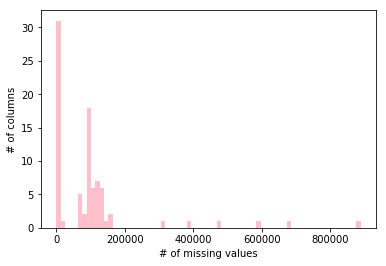

In [10]:
plt.hist(mu_data, bins=70, color = 'pink')
plt.ylabel('# of columns')
plt.xlabel('# of missing values')
plt.show()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the dataset.
per_col =(azdias.isnull().sum()/len(azdias))*100
per_col.head()

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
dtype: float64

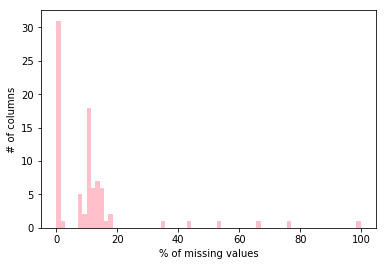

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(per_col, bins=70, color = 'pink')
plt.ylabel('# of columns')
plt.xlabel('% of missing values')
plt.show()


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#we can notice fron the histogram plot that after ~19 we can locate the ouliers using this info:
col= (azdias.isnull().sum()/len(azdias))*100
col = col[col>19]
#get the exact column in order to drop it
label= col.keys().tolist() 
#now drop all labels which are the exact columns that indetified as outliers
azdias = azdias.drop(label, axis=1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


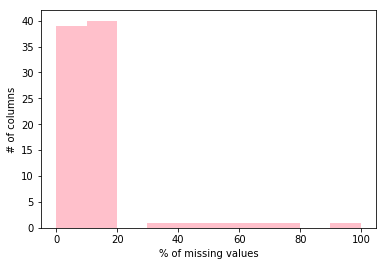

In [14]:
plt.hist(per_col, bins=10, color = 'pink')
plt.ylabel('# of columns')
plt.xlabel('% of missing values')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

The histogram plot made it very clear that almost after 19% the ouliers starts to shows in the figure.. we drop the columns after the 19% by finding their name and using drop to get rid of them.. then printing azdias.head() showed 79 columns instead of the previous 85 which means 6 columns were dropped and considered outliers.. therefore, after this step columns with missing data has been dropped 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
#same method on the rows as well
nmr = azdias.isnull().sum(axis = 1)
display(nmr.head())
nmr.sum()

0    43
1     0
2     0
3     7
4     0
dtype: int64

5035304

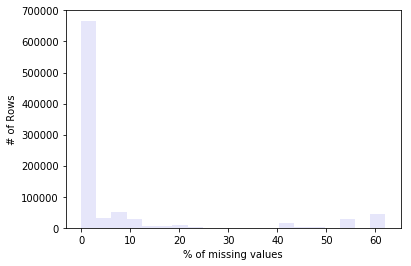

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
per_rw = nmr/azdias.shape[1]*100
per_rw
plt.hist(per_rw, bins=20, color = 'lavender')
plt.ylabel('# of Rows')
plt.xlabel('% of missing values')
plt.show()


In [17]:
#graph shows two sets in which data is represented.. doing a comparison for the two sets to decide which one will be dropped
subset1 = azdias[azdias.isnull().sum(axis=1) < 25]
subset1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [18]:
subset2 = azdias[azdias.isnull().sum(axis=1) >= 40]
subset2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
per_col =(azdias.isnull().sum()/len(azdias))*100
no_mu = per_col[per_col==0].index.tolist()
comparing_col= no_mu[:5]
comparing_col

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER']

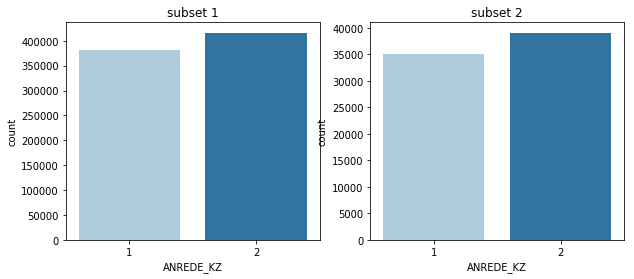

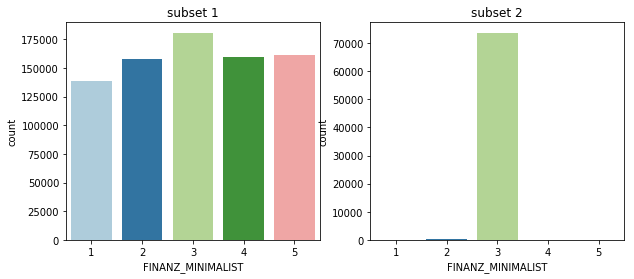

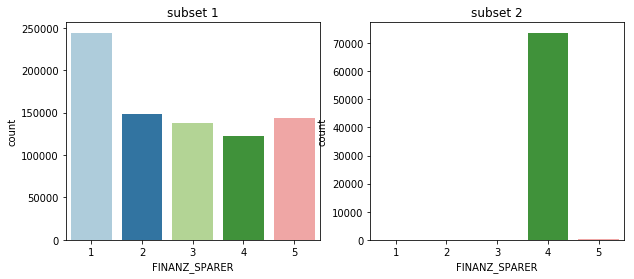

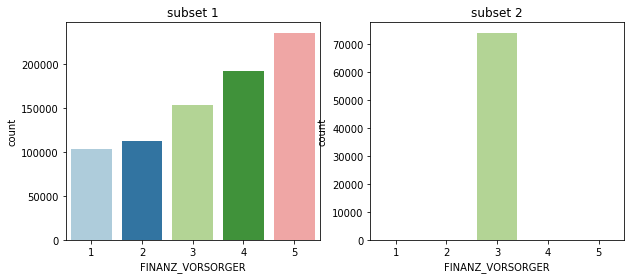

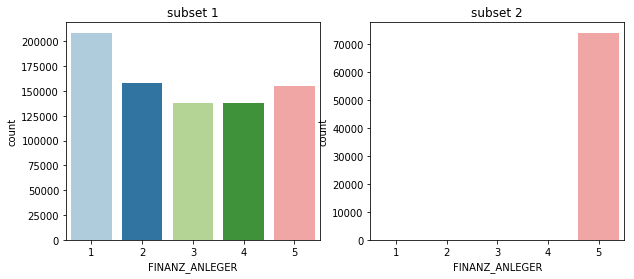

In [20]:
#https://seaborn.pydata.org/tutorial/color_palettes.html
def nuvsrows(col_label):
    size = plt.figure(figsize=(10,4))
    
    ax1 = size.add_subplot(121)
    ax1.title.set_text('subset 1')
    sns.countplot(subset1[col_label], palette="Paired")
    
    
    ax2 = size.add_subplot(122)
    ax2.title.set_text('subset 2')
    sns.countplot(subset2[col_label], palette = "Paired")
    plt.show()
    
for c in comparing_col:
    nuvsrows(c)

#### Discussion 1.1.3: Assess Missing Data in Each Row
Are the data with lots of missing values are qualitatively different from data with few or no missing values?
Yes, From analyzing Subset 1 and Subset 2 we can notice huge difference in boths sets.. data with no missing values or less is much more prefered as subset2 is showing a lot of gaps in the bar graph.. therefore I reached the conclusion of dropping subset2 and sticking to subset1 further ahead with the project with no rows that has a lot of missing values

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
#after getting to know what features and how many to deal with we can go further and engineer properly
num_feat = azdias.keys().tolist()
num_feat = feat_info[feat_info['attribute'].isin(num_feat)] 
num_feat['type'].value_counts()


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [22]:
num_feat

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For -, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_feat = num_feat[num_feat['type'] == 'categorical']['attribute']
cat_feat

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [24]:
#https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
#https://towardsdatascience.com/encoding-categorical-variables-in-machine-learning-5644a43c123f
#initialize lists to append multi and binary
binary = []
multi = []
for num_feat in cat_feat:
    #more than 2 add to multi 
    if (subset1[num_feat].nunique() == 2):
        binary.append(num_feat)
    # append the binary
    else:
        multi.append(num_feat)
#now we have two lists.. binary and multi we can engineer the lists easily after knowing what they contain        
display(binary)
subset1[binary].head()

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W


In [25]:
#as shown 'ANREDE_KZ', 'OST_WEST_KZ' and 'VERS_TYP' needs to be converted to binary (replace with 0, 1)
subset1['ANREDE_KZ'].replace([1,2], [0,1], inplace=True)
subset1['VERS_TYP'].replace([1.0,2.0], [0,1], inplace=True)
subset1.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace = True)
#binary list are converted correctly and can be shown 
subset1[binary].head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,1,0,1.0,1.0,0
2,1,1,0.0,0.0,0
3,1,0,0.0,0.0,0
4,0,0,0.0,1.0,0
5,1,0,0.0,1.0,0


In [26]:
#check the list of multi features appended from the loop
subset1[multi].head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4,4C
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2,2A
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6,6B
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8,8C


In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
#decided to drop the multi feature columns
subset1 = subset1.drop(multi, axis=1)
subset1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,1,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

 Which ones did you keep, which did you drop, and what engineering steps did you perform?
 I have kept the binary after converting each feature correctly to 0,1, here i made sure to print binary list heads that are claimed to be binary from the loop created.. then after that I could notice the data that is not actually 0 and 1.. with a simple replace this issue was fixed and then I have decided to drop the multi catergorical feature as engineering it didnt not seem worth the time right now. therefore, after this step our data is no longer with binary columns that are not correctly presented as 0,1 and there is no multi feature columns

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
#from the note it is given two features that mixed and needs engineering
#this step to confirm the other mixed features so it wont cause me problems later on
mix_feat = feat_info[feat_info['type'] == 'mixed']['attribute']
mix_feat.head()

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
Name: attribute, dtype: object

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
subset1['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [30]:
#subset1['DECADE']

In [31]:
#subset1['MOVEMENT']

In [32]:
#https://knowledge.udacity.com/questions/115912
#from Data_Dictionary.md a dict has been made to replace the mixed feature
decade={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
movement={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

subset1['DECADE'] = subset1['PRAEGENDE_JUGENDJAHRE']
subset1['DECADE'].replace(decade, inplace = True)

subset1['MOVEMENT'] = subset1['PRAEGENDE_JUGENDJAHRE']
subset1['MOVEMENT'].replace(movement, inplace = True)
   

In [33]:
#https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
#using map and apply we engineer accordignly 
"""

def mapdecade(num):
    try:
        for key, array in decade.items():
            if num in array:
                return key
    except ValueError:
        return np.nan
"""

'\n\ndef mapdecade(num):\n    try:\n        for key, array in decade.items():\n            if num in array:\n                return key\n    except ValueError:\n        return np.nan\n'

In [34]:
"""
def mapmovement(num1):
    try:
        if num1 in movement:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan
"""

'\ndef mapmovement(num1):\n    try:\n        if num1 in movement:\n            return 0\n        else:\n            return 1\n    except ValueError:\n        return np.nan\n'

In [35]:
#subset1['PRAEGENDE_JUGENDJAHRE_decade'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(mapdecade)
#subset1['PRAEGENDE_JUGENDJAHRE_movement'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(mapmovement)

In [36]:
subset1['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
subset1['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [38]:
#from Data_Dictionary.md a dict has been made to replace the mixed feature

wealth = {
    
    '11':1, '21':2, '31':3, '41':4, '51':5, 
    '12':1, '22':2, '32':3, '42':4, '52':5, 
    '13':1, '23':2, '33':3, '43':4, '53':5, 
    '14':1, '24':2, '34':3, '44':4, '54':5, 
    '15':1, '25':2, '35':3, '45':4, '55':5,  }

lifestage ={
    '11':1, '12':2, '13':3, '14':4, '15':5, 
    '21':1, '22':2, '23':3, '24':4, '25':5, 
    '31':1, '32':2, '33':3, '34':4, '35':5, 
    '41':1, '42':2, '43':3, '44':4, '45':5, 
    '51':1, '52':2, '53':3, '54':4, '55':5, }


subset1['WEALTH'] = subset1['CAMEO_INTL_2015']
subset1['WEALTH'].replace(wealth, inplace = True)

subset1['LIFE_STAGE'] = subset1['CAMEO_INTL_2015']
subset1['LIFE_STAGE'].replace(lifestage, inplace = True)

In [39]:
#the two in concern mixed feat has been dealt with already I used drop for the other mixed on to make sure it wont hold me back
#mixed will hold the remaning of mixed feature left other than the two engineered in the prev cells
mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed = [x for x in mixed if x in subset1.columns]
#after fetching them.. simply drop from the set
subset1.drop(mixed, axis=1, inplace=True)

In [40]:
#subset1 = subset1.drop(mix_feat, axis= 1)

In [41]:
subset1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
Two were engineered "PRAEGENDE_JUGENDJAHRE" "CAMEO_INTL_2015", by creating two dict for each feature according to data dictonary.. then replacing them instead of the current 
and the rest were dropped in order not to cause any problems further ahead

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
np.unique(subset1.dtypes.values)

array([dtype('int64'), dtype('float64')], dtype=object)

In [43]:
subset_col = subset1.keys().tolist()
imputer = Imputer(missing_values='NaN',strategy='mean',axis=0)
subset1 = imputer.fit_transform(subset1)
subset1 = pd.DataFrame(subset1, columns=subset_col)

In [44]:
subset1.head(15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.000000,5.000000,4.000000,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.000000,4.000000,4.000000,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.000000,3.000000,4.000000,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.000000,3.000000,3.000000,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.000000,5.000000,5.000000,2.0,3.0,3.0,2.0,1.0,5.0,4.0
5,2.0,1.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0.000000,5.000000,5.000000,4.0,6.0,3.0,5.0,1.0,2.0,2.0
6,1.0,0.0,3.0,3.0,4.0,1.0,3.0,2.0,0.0,1.0,...,0.000000,4.000000,4.000000,2.0,5.0,2.0,4.0,1.0,1.0,4.0
7,3.0,0.0,4.0,4.0,2.0,4.0,2.0,2.0,1.0,3.0,...,1.000000,3.000000,3.000000,2.0,4.0,3.0,5.0,0.0,1.0,3.0
8,3.0,1.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,2.0,...,1.000000,3.000000,3.000000,2.0,3.0,1.0,6.0,0.0,1.0,5.0
9,3.0,1.0,2.0,2.0,5.0,3.0,1.0,5.0,0.0,2.0,...,0.000000,3.000000,3.000000,4.0,6.0,5.0,2.0,1.0,5.0,1.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
#reintroduce all the methods used above into one function to make step 3 way easier 
def clean_data(df, feat_info):
    
#-----------------------------------------------------------------------------------------------------------      
    # convert missing value codes into NaNs, ...
    for x in range(len(feat_info)): 
        mu_data = feat_info.iloc[x]['missing_or_unknown']
        #remove [] and ,
        mu_data = mu_data.strip(']') 
        mu_data = mu_data.strip('[') 
        mu_data = mu_data.split(sep=',') 
    #acknowledge if not! case
        mu_data = [int(x) if (x!='' and x!='X' and x!='XX') else x for x in mu_data] 
        if mu_data != ['']:
            df = df.replace({feat_info.iloc[x]['attribute']: mu_data}, np.nan)
    print("Convert missing values codes into Nans: ")
    display(df.head())
#-----------------------------------------------------------------------------------------------------------    
    # remove selected columns and rows, ...
    #columns first

    #columns=['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ']
    #df.drop(columns=columns,axis="columns",inplace=True)
    #col= (df.isnull().sum()/len(df))*100
    #col = col[col>19]
    #get the exact column in order to drop it
    #label= col.keys().tolist() 
    df = df.drop(label, axis=1)
    print("removing selected columns: ")
    display(df.head())    
    #now for rows 
    print("Removing selected rows: ")
    nmr = df.isnull().sum(axis = 1)
    per_rw = nmr/df.shape[1]*100
    df = df[df.isnull().sum(axis=1) < 25] 
    
    display(df.head())
    
#-----------------------------------------------------------------------------------------------------------    

    df = df.drop(multi, axis=1)
    
    print("drop multi features: ")
    display(df.head())

#-----------------------------------------------------------------------------------------------------------    
   
    df['ANREDE_KZ'].replace([1,2], [0,1], inplace=True)
    df['VERS_TYP'].replace([1.0,2.0], [0,1], inplace=True)
    df.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace = True) 
    
    print("convert correctly to binary: ")
    display(df[binary].head()) 
    display(df.head())
#-----------------------------------------------------------------------------------------------------------       
    
    df["DECADE"]=df.PRAEGENDE_JUGENDJAHRE
    df["MOVEMENT"]=df.PRAEGENDE_JUGENDJAHRE
    decade={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    df["DECADE"].replace(decade,inplace=True)
    df["MOVEMENT"].replace(movement,inplace=True)
    
    wealth = { 
    '11':1, '21':2, '31':3, '41':4, '51':5, 
    '12':1, '22':2, '32':3, '42':4, '52':5, 
    '13':1, '23':2, '33':3, '43':4, '53':5, 
    '14':1, '24':2, '34':3, '44':4, '54':5, 
    '15':1, '25':2, '35':3, '45':4, '55':5,  }

    lifestage ={
    '11':1, '12':2, '13':3, '14':4, '15':5, 
    '21':1, '22':2, '23':3, '24':4, '25':5, 
    '31':1, '32':2, '33':3, '34':4, '35':5, 
    '41':1, '42':2, '43':3, '44':4, '45':5, 
    '51':1, '52':2, '53':3, '54':4, '55':5, }

    df['WEALTH'] = df.CAMEO_INTL_2015
    df['WEALTH'].replace(wealth, inplace = True)

    df['LIFE_STAGE'] = df.CAMEO_INTL_2015
    df['LIFE_STAGE'].replace(lifestage, inplace = True)
#-----------------------------------------------------------------------------------------------------------       
    #CAMEO_DEUG_2015          791800 non-null object
    #CAMEO_DEU_2015           791800 non-null object
    #df=df.drop(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"])
    
    # Remove all mixed variables inplace to reduce complexity
    mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed = [x for x in mixed if x in df.columns]
    df.drop(mixed, axis=1, inplace=True)
    print("Re-encoding and engineering for column values: ")
    display(df.head())
    df.info()
#----------------------------------------------------------------------------------------------------------- 
    #df["CAMEO_DEU_2015"].drop
    #df["CAMEO_DEUG_2015"].drop
#----------------------------------------------------------------------------------------------------------- 
    df_col = df.keys().tolist()
    imputer = Imputer(missing_values='NaN',strategy='mean',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns=df_col)
    print("Replacing NaN Values: ")
    display(df.head())
#-----------------------------------------------------------------------------------------------------------
    print("Cleaned data: ")
    display(df.head())    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
# Apply feature scaling to the general population demographics data.
azdias_general = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
azdias_general = clean_data(azdias_general, feat_info)
azdias_general_columns = azdias_general.keys().tolist()

Convert missing values codes into Nans: 


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


removing selected columns: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Removing selected rows: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


drop multi features: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


convert correctly to binary: 


,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,1,0,1.0,1.0,0
2,1,1,0.0,0.0,0
3,1,0,0.0,0.0,0
4,0,0,0.0,1.0,0
5,1,0,0.0,1.0,0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,1,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


Re-encoding and engineering for column values: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 797906 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     795106 non-null float64
ANREDE_KZ                797906 non-null int64
FINANZ_MINIMALIST        797906 non-null int64
FINANZ_SPARER            797906 non-null int64
FINANZ_VORSORGER         797906 non-null int64
FINANZ_ANLEGER           797906 non-null int64
FINANZ_UNAUFFAELLIGER    797906 non-null int64
FINANZ_HAUSBAUER         797906 non-null int64
GREEN_AVANTGARDE         797906 non-null int64
HEALTH_TYP               761235 non-null float64
RETOURTYP_BK_S           793228 non-null float64
SEMIO_SOZ                797906 non-null int64
SEMIO_FAM                797906 non-null int64
SEMIO_REL                797906 non-null int64
SEMIO_MAT                797906 non-null int64
SEMIO_VERT               797906 non-null int64
SEMIO_LUST               797906 non-null int64
SEMIO_ERL                797906 non-null int64
SEMIO_KULT               797906 non-n

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


Cleaned data: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [47]:
azdias_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797906 entries, 0 to 797905
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     797906 non-null float64
ANREDE_KZ                797906 non-null float64
FINANZ_MINIMALIST        797906 non-null float64
FINANZ_SPARER            797906 non-null float64
FINANZ_VORSORGER         797906 non-null float64
FINANZ_ANLEGER           797906 non-null float64
FINANZ_UNAUFFAELLIGER    797906 non-null float64
FINANZ_HAUSBAUER         797906 non-null float64
GREEN_AVANTGARDE         797906 non-null float64
HEALTH_TYP               797906 non-null float64
RETOURTYP_BK_S           797906 non-null float64
SEMIO_SOZ                797906 non-null float64
SEMIO_FAM                797906 non-null float64
SEMIO_REL                797906 non-null float64
SEMIO_MAT                797906 non-null float64
SEMIO_VERT               797906 non-null float64
SEMIO_LUST               797906 non-null float64
SEMIO_ERL                797906 non-null float64
SEMIO_K

In [48]:
#For the actual scaling function, a StandardScaler instance is suggested, scaling each feature to mean 0 and standard deviation 1.
from sklearn.preprocessing import StandardScaler

feat_scaler = StandardScaler()
azdias_general = feat_scaler.fit_transform(azdias_general)

### Discussion 2.1: Apply Feature Scaling

The data has been cleaned using the same previous steps summarized in the clean_data function.. afterwards standarscaler has been applied with fit_transform to scale each feature to mean 0 and std 1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
p=PCA()
p.fit(azdias_general)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [50]:
"""explained_variance_ratio_ndarray of shape (n_components,)
Percentage of variance explained by each of the selected components.

If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0."""

p.explained_variance_ratio_

array([  1.68118599e-01,   1.34514542e-01,   9.47637184e-02,
         5.26349702e-02,   3.76450832e-02,   3.17706534e-02,
         2.79858447e-02,   2.48999920e-02,   2.33317002e-02,
         2.12209764e-02,   2.08051616e-02,   2.05637280e-02,
         1.86986925e-02,   1.77234591e-02,   1.66629822e-02,
         1.60259683e-02,   1.56191230e-02,   1.45131399e-02,
         1.31723000e-02,   1.29829511e-02,   1.22418982e-02,
         1.20401595e-02,   1.16463298e-02,   1.10703697e-02,
         1.08160019e-02,   9.07243122e-03,   7.87043592e-03,
         7.47856493e-03,   7.40571145e-03,   7.17681297e-03,
         6.87674756e-03,   6.54296699e-03,   6.49529990e-03,
         6.29811632e-03,   6.03878580e-03,   5.96046652e-03,
         5.42589520e-03,   4.98239400e-03,   4.89543709e-03,
         4.48617547e-03,   4.31895946e-03,   4.10155651e-03,
         4.00219117e-03,   3.90263722e-03,   3.86875970e-03,
         3.48274759e-03,   3.24064282e-03,   3.18260643e-03,
         3.02546585e-03,

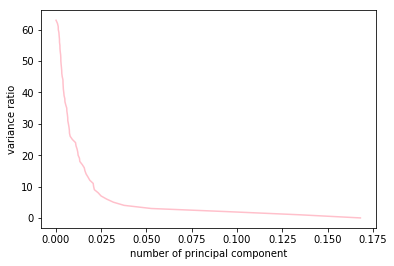

In [51]:
# Investigate the variance accounted for by each principal component.
#it appears to be inverse.. create another plot to preform better analysis(inverse)
x=p.explained_variance_ratio_
y=np.arange(len(x))

plt.plot(x,y, color= 'pink')
plt.xlabel("number of principal component")
plt.ylabel("variance ratio")
plt.show()

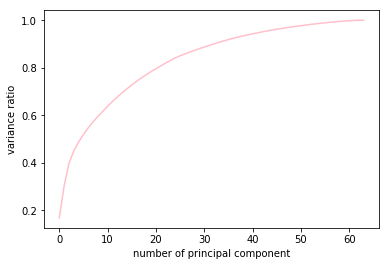

In [52]:
#this visualization will be the key to deal with
#cumsum() function is used when we want to compute the cumulative sum of array elements over a given axis. 
plt.plot(range(x.shape[0]), np.cumsum(x), color = 'pink')
plt.xlabel("number of principal component")
plt.ylabel("variance ratio")
plt.show()

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
p = PCA(n_components = 40)
p_azdias_data = p.fit_transform(azdias_general)

### Discussion 2.2: Perform Dimensionality Reduction

How many principal components / transformed features are you retaining for the next step of the analysis?
while visualizing the data we could notice it is an exp graph.. while trying to retain as much data as possible I decided to cut from almost the max of the graph on 40 principle components.. as we can notice after 40 the graph gets to a constant and seems like retaining on 40 would be the best choice to having perfect amount of principals. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(p, s):
    w = pd.DataFrame(p.components_, columns = azdias_general_columns)
    return w.iloc[s].sort_values(ascending = False)
    

In [55]:
map_weights(p , 0)

PLZ8_ANTG3               0.227751
PLZ8_ANTG4               0.220936
WEALTH                   0.208190
HH_EINKOMMEN_SCORE       0.204420
ORTSGR_KLS9              0.198451
EWDICHTE                 0.196696
FINANZ_HAUSBAUER         0.163479
PLZ8_ANTG2               0.154943
KBA05_ANTG4              0.153921
ARBEIT                   0.144543
FINANZ_SPARER            0.142629
ANZ_HAUSHALTE_AKTIV      0.136803
RELAT_AB                 0.136385
KBA05_ANTG3              0.135984
SEMIO_PFLICHT            0.111596
SEMIO_REL                0.108644
MOVEMENT                 0.107153
DECADE                   0.097385
SEMIO_RAT                0.091410
SEMIO_TRADV              0.084995
SEMIO_MAT                0.075633
SEMIO_FAM                0.075072
REGIOTYP                 0.073247
FINANZ_UNAUFFAELLIGER    0.069978
SEMIO_KULT               0.069487
FINANZ_ANLEGER           0.066137
OST_WEST_KZ              0.054209
KKK                      0.044085
SEMIO_SOZ                0.042029
PLZ8_HHZ      

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(p , 1)


ALTERSKATEGORIE_GROB     0.261394
FINANZ_VORSORGER         0.234436
SEMIO_ERL                0.231106
SEMIO_LUST               0.184343
RETOURTYP_BK_S           0.163817
W_KEIT_KIND_HH           0.119240
FINANZ_HAUSBAUER         0.115165
SEMIO_KRIT               0.114770
SEMIO_KAEM               0.111228
ANREDE_KZ                0.089563
PLZ8_ANTG3               0.088589
EWDICHTE                 0.088080
ORTSGR_KLS9              0.086574
PLZ8_ANTG4               0.084575
WEALTH                   0.071299
SEMIO_DOM                0.070254
FINANZ_MINIMALIST        0.069423
KBA05_ANTG4              0.065778
ARBEIT                   0.065036
RELAT_AB                 0.062531
WOHNDAUER_2008           0.061776
PLZ8_ANTG2               0.061062
ANZ_HAUSHALTE_AKTIV      0.060844
HH_EINKOMMEN_SCORE       0.053506
KBA05_ANTG3              0.040264
VERS_TYP                 0.033716
ANZ_HH_TITEL             0.030449
OST_WEST_KZ              0.024717
REGIOTYP                 0.020667
MOVEMENT      

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(p , 2)


SEMIO_VERT               0.345260
SEMIO_SOZ                0.262520
SEMIO_FAM                0.250184
SEMIO_KULT               0.235625
FINANZ_MINIMALIST        0.155894
RETOURTYP_BK_S           0.108290
FINANZ_VORSORGER         0.100904
W_KEIT_KIND_HH           0.090747
ALTERSKATEGORIE_GROB     0.078669
SEMIO_REL                0.069780
SEMIO_LUST               0.064306
SEMIO_MAT                0.055620
GREEN_AVANTGARDE         0.046970
ORTSGR_KLS9              0.045931
EWDICHTE                 0.045325
PLZ8_ANTG4               0.044864
PLZ8_ANTG3               0.044473
ARBEIT                   0.034583
WOHNDAUER_2008           0.033070
RELAT_AB                 0.031466
PLZ8_ANTG2               0.029670
WEALTH                   0.027424
KBA05_ANTG4              0.026667
ANZ_HAUSHALTE_AKTIV      0.025315
OST_WEST_KZ              0.015216
ANZ_HH_TITEL             0.013243
VERS_TYP                 0.011769
ANZ_TITEL                0.009587
KBA05_ANTG3              0.007776
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?

First Component:

I could notice very high positive correlation runs from PLZ8_ANTG3 and starts decreasing up to SEMIO_KRIT:
PLZ8_ANTG3               0.227751, Number of 6-10 family houses in the PLZ8 regions.
SEMIO_KRIT               0.005091, Personality typology, critical-minded

Those were the highest and lowest positive correlations 
after that the negative correlation starts from SOHO_KZ and keeps dropping to MOBI_REGIO..  
SOHO_KZ                 -0.002024, Small office / home office flag
MOBI_REGIO              -0.243173,Movement patterns
those showed lowest negative correlations

.. but the drop in the negative correlation is not as high as the positive as there was more negative correlations in the first component.

Second Component: 

I could notice very high positive correlation runs from ALTERSKATEGORIE_GROB and starts decreasing up to OST_WEST_KZ:

ALTERSKATEGORIE_GROB     0.261394, Estimated age based on given name analysis
FINANZ_VORSORGER         0.234436, Financial typology, be prepared
OST_WEST_KZ              0.024717, Building location via former East / West Germany 

Those were the highest and lowest positive correlations 

after that the negative correlation starts from SOHO_KZ and keeps dropping to MOBI_REGIO.. 

SOHO_KZ                 -0.001857,  Small office / home office flag
KBA05_ANTG2             -0.009754, Number of 3-5 family houses in the microcell

those showed lowest negative correlations


Third Component: 

I could notice very high positive correlation runs from SEMIO_VERT            and starts decreasing up to PLZ8_HHZ:

SEMIO_VERT               0.345260, Personality typology, dreamful
PLZ8_HHZ                 0.003917, Number of households within the PLZ8 region

Those were the highest and lowest positive correlations 

after that the negative correlation starts from KBA05_ANTG2 and keeps dropping to ANREDE_KZ..  

KBA05_ANTG2             -0.010788, Number of 3-5 family houses in the 
KKK                     -0.013505, Purchasing power in region
SEMIO_KAEM              -0.337106, Personality typology, combative attitude
ANREDE_KZ               -0.368739, gender

those showed lowest negative correlations

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
#https://www.analythttps://viewrygazrvtgq.udacity-student-workspaces.com/notebooks/Identify_Customer_Segments.ipynb#icsvidhya.com/blog/2020/12/a-detailed-introduction-to-k-means-clustering-in-python/#:~:text=Cluster%20analysis%20or%20clustering%20is,and%20low%20inter%2Dcluster%20similarity.
from sklearn.cluster import KMeans

# Over a number of different cluster counts (13)...
cluster = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# run k-means clustering on the data and...
scores = []      
for c in cluster:
    kmeans = KMeans(n_clusters = c)
    model = kmeans.fit(p_azdias_data)
# compute the average within-cluster distances.
#The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. 
#Try applying it to a small, toy dataset, or use an internet search to help your understanding.
#https://www.kaggle.com/getting-started/27261
    score = np.abs(model.score(p_azdias_data))
    scores.append(score)  
#takes ~35mins to finish running

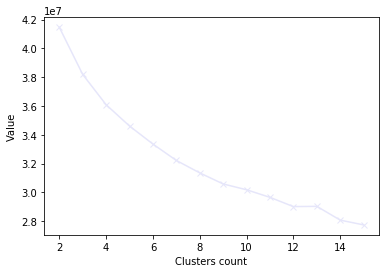

In [59]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster, scores, marker = 'x', color = 'lavender')
plt.xlabel('Clusters count')
plt.ylabel('Value')
plt.show()

In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 12)
model = kmeans.fit(p_azdias_data)
predict_azdias = model.predict(p_azdias_data)


### Discussion 3.1: Apply Clustering to General Population

Into how many clusters have you decided to segment the population?
using elbow method made me wonder between 12 and 13.. as it shows in the graph it both has the same value and it is where the graph showed elbow.. so I have decided to go for 12 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [62]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers, feat_info)


Convert missing values codes into Nans: 


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


removing selected columns: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1,5.0,5,1,5,1,2,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,4.0,1,NaN,5,1,5,1,3,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,2,2.0,5,1,5,1,4,4,2,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,1,2.0,5,1,5,2,1,2,6,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,1,6.0,3,1,4,4,5,2,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


Removing selected rows: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1,5.0,5,1,5,1,2,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
2,4.0,2,2.0,5,1,5,1,4,4,2,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,1,2.0,5,1,5,2,1,2,6,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,1,6.0,3,1,4,4,5,2,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,3.0,1,4.0,5,1,5,1,2,3,5,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0


drop multi features: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1,5,1,5,1,2,2,1,1.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0


convert correctly to binary: 


,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,0,1,0.0,0.0,0
2,1,1,0.0,1.0,0
3,0,0,0.0,0.0,0
4,0,0,0.0,1.0,0
5,0,1,0.0,1.0,0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,0,5,1,5,1,2,2,1,1.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
2,4.0,1,5,1,5,1,4,4,1,2.0,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,4.0,0,5,1,5,2,1,2,0,2.0,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,3.0,0,3,1,4,4,5,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,3.0,0,5,1,5,1,2,3,1,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0


Re-encoding and engineering for column values: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,0,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
2,4.0,1,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,4.0,0,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,0,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,0,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 141701 entries, 0 to 191651
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     141468 non-null float64
ANREDE_KZ                141701 non-null int64
FINANZ_MINIMALIST        141701 non-null int64
FINANZ_SPARER            141701 non-null int64
FINANZ_VORSORGER         141701 non-null int64
FINANZ_ANLEGER           141701 non-null int64
FINANZ_UNAUFFAELLIGER    141701 non-null int64
FINANZ_HAUSBAUER         141701 non-null int64
GREEN_AVANTGARDE         141701 non-null int64
HEALTH_TYP               139366 non-null float64
RETOURTYP_BK_S           138593 non-null float64
SEMIO_SOZ                141701 non-null int64
SEMIO_FAM                141701 non-null int64
SEMIO_REL                141701 non-null int64
SEMIO_MAT                141701 non-null int64
SEMIO_VERT               141701 non-null int64
SEMIO_LUST               141701 non-null int64
SEMIO_ERL                141701 non-null int64
SEMIO_KULT               141701 non-n

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,0.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
1,4.0,1.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
2,4.0,0.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
3,3.0,0.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
4,3.0,0.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


Cleaned data: 


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,0.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
1,4.0,1.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
2,4.0,0.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
3,3.0,0.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
4,3.0,0.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


In [63]:
customers = feat_scaler.transform(customers)
p_customers= p.transform(customers)
predict_customers = model.predict(p_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

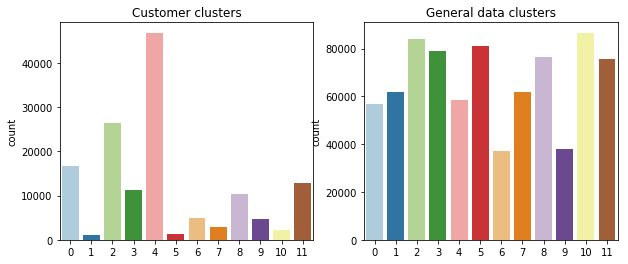

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Customer clusters')
sns.countplot(predict_customers, palette = 'Paired')

ax2 = fig.add_subplot(122)
ax2.title.set_text('General data clusters')
sns.countplot(predict_azdias, palette = 'Paired')
plt.show()

In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster4 = model.cluster_centers_[4]
p4 = p.inverse_transform(cluster4)

over = feat_scaler.inverse_transform(p4)
over = pd.Series(data = over, index = azdias_general_columns)
over.head()


ALTERSKATEGORIE_GROB    3.288690
ANREDE_KZ               0.048255
FINANZ_MINIMALIST       4.809006
FINANZ_SPARER           1.629443
FINANZ_VORSORGER        4.173616
dtype: float64

In [69]:
cluster2 = model.cluster_centers_[2]
p2 = p.inverse_transform(cluster2)

over = feat_scaler.inverse_transform(p2)
over = pd.Series(data = over, index = azdias_general_columns)
over.head()

ALTERSKATEGORIE_GROB    3.286817
ANREDE_KZ               0.087194
FINANZ_MINIMALIST       4.498408
FINANZ_SPARER           1.749764
FINANZ_VORSORGER        4.106196
dtype: float64

In [70]:
cluster5 = model.cluster_centers_[5]
p5 = p.inverse_transform(cluster5)

over = feat_scaler.inverse_transform(p5)
over = pd.Series(data = over, index = azdias_general_columns)
over.head()

ALTERSKATEGORIE_GROB    1.671616
ANREDE_KZ               0.999738
FINANZ_MINIMALIST       1.184951
FINANZ_SPARER           4.261782
FINANZ_VORSORGER        2.179781
dtype: float64

In [68]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster1 = model.cluster_centers_[1]
p1 = p.inverse_transform(cluster1)

under = feat_scaler.inverse_transform(p1)
under= pd.Series(data = under, index = azdias_general_columns)
under.head()


ALTERSKATEGORIE_GROB    1.818302
ANREDE_KZ              -0.031731
FINANZ_MINIMALIST       1.888216
FINANZ_SPARER           4.422133
FINANZ_VORSORGER        2.110629
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

 reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?
 
 1 and 5 showed as the most underreprsented in the bar graph with the comparison, so it would be recommended to avoid this cluster


ALTERSKATEGORIE_GROB    1.818302 the age is < 30 years old .. younger people we could say
ANREDE_KZ              -0.031731 the gender seems to be undetermined (close to 0 )
FINANZ_MINIMALIST       1.888216, very high on finanicial interest
FINANZ_SPARER           4.422133, low on money saver
FINANZ_VORSORGER        2.110629, high on be prepared


Financial typology: High, very high, high.. bascially we could tell high finanancial typology tend to be underrepresented.

#-------------------------------------------------------------------------

however, cluster 4 and 2 showed great overrepresentation as it could be a great potential targets.. the type of people are:


ALTERSKATEGORIE_GROB    3.288690 3.484152 the age 46 - 60 years old .. older people in general
ANREDE_KZ               0.048255 the gender is undetermined
FINANZ_MINIMALIST       4.809006 low, financial interest
FINANZ_SPARER           1.629443 high, saving money
FINANZ_VORSORGER        4.173616 low, be prepared

financial typology in the overrepresented and the better targets as the financial interest is low and high on money saving and low on being prepared

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.